## Задача 5. Экспериментальное исследование алгоритмов для регулярных запросов

### Постановка задачи
Решаются следующие задачи достижимости:
1. Достижимость между всеми парами вершин.
2. Достижимость для всего множества заданных стартовых вершин.
3. Достижимость для каждой из заданного множества стартовых вершин.

### Набор данных
Для полноты эксперимента были выбраны несколько графов:
1. [biomedical](https://jetbrains-research.github.io/CFPQ_Data/dataset/data/biomedical.html) - 341 вершина, 459 ребер.
2. [funding](https://jetbrains-research.github.io/CFPQ_Data/dataset/data/funding.html) - 778 вершин, 1086 ребер.
3. [core](https://jetbrains-research.github.io/CFPQ_Data/dataset/data/core.html) - 1323 вершины, 2752 ребра.
3. [enzyme](https://jetbrains-research.github.io/CFPQ_Data/dataset/data/enzyme.html) -  48815 вершин, 86543 ребра.

Все графы имеют разное число вершин, но при этом они не слишком большие, чтобы суммарное время их выполнения было
в пределах часа.


Регулярные запросы к графам строятся по следующему шаблону:
1. (n1 | n2 | n3 )* n0)
* (n0 | n1 | n2 )+ n3)
* (n0 n1)* (n0 n2)*
* n0 n2 (n0 | n3)*,

где n0, ..., nk - все метки графа в порядке убывания частоты их появления в графе.

Алгоритм запускался также со следующими вариантами матриц:
1. lil_matrix
2. csr_matrix
3. csc_matrix
4. dok_matrix


### Описание эксперимента

Цель данный работы - ответить на следующие вопросы:

1. Какое представление разреженных матриц и векторов лучше подходит для каждой из решаемых задач?
2. Начиная с какого размера стартового множества выгоднее решать задачу для всех пар и
выбирать нужные?
3. На сколько решение второй задачи медленнее решения третьей при одинаковых начальных условиях?

Для ответа на данные вопросы была реализована функция, которая для каждой из задач подсчитывает время работы
алгоритма регулярного запроса к графу.

Данная функция запускает тесты с различным числом стартовых вершин, для всех стартовых вершин вместе
или для каждой отдельно, с указанным набором матриц, а также с графами, на которых будет запускаться алгоритм.
Каждая конфигурация запускается по пять раз, что повышает точность полученного результата.


In [25]:
from scipy import mean
from cfpq_data import generate_multiple_source_percent
from project.__main__ import *

def experiment(percents=None, separated=True, matrix_types=None, taskn=1, graphs=None):
    if graphs is None:
        graphs = ['biomedical', 'funding', 'core']
    if percents is None:
        percents = [100]
    if matrix_types is None:
        matrix_types = [lil_matrix, csr_matrix, csc_matrix, dok_matrix]

    def regex_for_graph(gr):
        ls = list()
        for edge in gr.edges(data="label"):
            ls.append(edge[2])
        ls = [label for (label, _) in Counter(ls).most_common(4)]
        return [Regex(f'({ls[1]}|{ls[2]}|{ls[3]})*{ls[0]}'),
                Regex(f'({ls[0]}|{ls[1]}|{ls[2]})({ls[0]}|{ls[1]}|{ls[2]})*{ls[3]}'),
                Regex(f'({ls[0]} {ls[1]})* ({ls[0]} {ls[2]})*'),
                Regex(f'{ls[0]} {ls[2]} ({ls[0]}|{ls[3]})*')]

    print()
    for graph_name in graphs:
        graph = gm.get_graph_by_name(graph_name)
        bool_matrix_for_graph = BooleanMatrixAutomata(
            build_nfa_from_graph(graph, None, None), matrix_types[0]
        )
        regexes = regex_for_graph(graph)
        t = {per: {mat: {mean: [], tstd: []} for mat in matrix_types} for per in percents}
        for nr, regex in enumerate(regexes):
            bool_matrix_for_regex = BooleanMatrixAutomata(build_minimal_dfa_from_regex(regex), matrix_types[0])
            for per in percents:
                for mat_type in matrix_types:
                    times = list()
                    for i in range(5):
                        bool_matrix_for_graph.type_of_matrix = mat_type
                        bool_matrix_for_graph.start_state_indexes = generate_multiple_source_percent(graph, per, seed=3)
                        bool_matrix_for_regex.type_of_matrix = mat_type
                        start_time = time.time()
                        bool_matrix_for_graph.bfs_based_rpq(bool_matrix_for_regex, separated)
                        times.append(time.time() - start_time)
                    mean_t = mean(times)
                    tstd_t = tstd(times)
                    t[per][mat_type][mean].append(mean_t)
                    t[per][mat_type][tstd].append(tstd_t)

        index = np.arange(0, 5, 1.25)
        bw = 0.28
        colors = ['r', 'g', 'b', 'y']

        title = graph_name
        if taskn == 1:
            plt.xticks(index + 2 * bw, [1, 2, 3, 4])
            if percents[0] == 100:
                title += ' для всех пар вершин'
            elif not separated:
                title += ' для всего множества стартовых вершин'
            else:
                title += ' для каждой из заданных стартовых вершин'
            plt.xlabel("regex", fontsize=14)
            for i, mat in enumerate(matrix_types):
                plt.bar(index + i * bw, t[percents[0]][mat][mean], bw, yerr=t[percents[0]][mat][tstd],
                        error_kw={'ecolor': '0.1', 'capsize': 6}, alpha=0.7, color=colors[i], label=mat.__name__)
        else:
            plt.xticks(index + 2 * bw, percents)
            plt.xlabel("percent", fontsize=14)
            for i, per in enumerate(percents):
                plt.bar(index + i * bw, t[per][lil_matrix][mean], bw, alpha=0.7, color=colors[i], label=per)
            if taskn == 2:
                title += ' для всего множества стартовых вершин' 
            else:
                title += ' для каждой из заданных стартовых вершин'
        plt.ylabel("секунд", fontsize=14)
        plt.title(title)
        plt.legend(loc=1)
        plt.show()

### 1. Какое представление разреженных матриц и векторов лучше подходит для каждой из решаемых задач?


C:\Users\slava\AppData\Local\Temp\ipykernel_15368\1001431462.py:46: DeprecationWarning: scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead
  mean_t = mean(times)


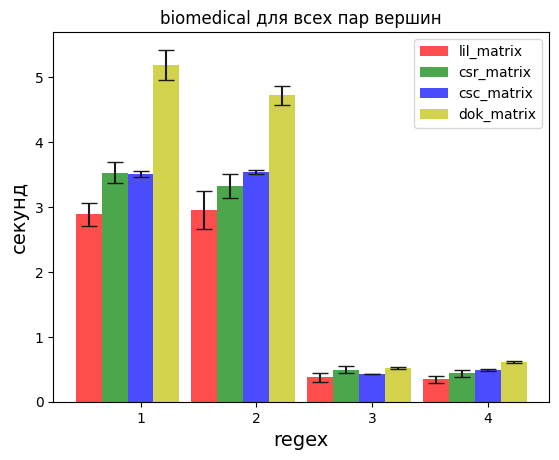

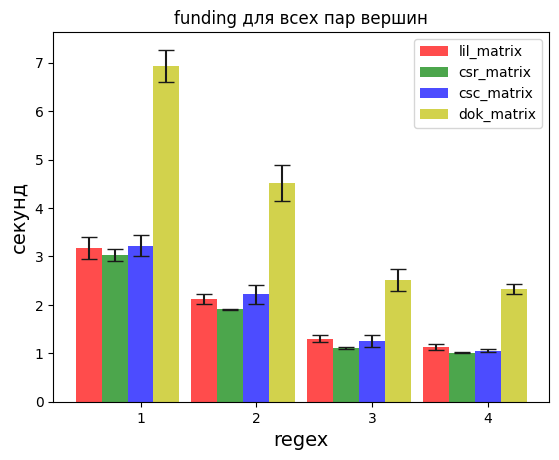

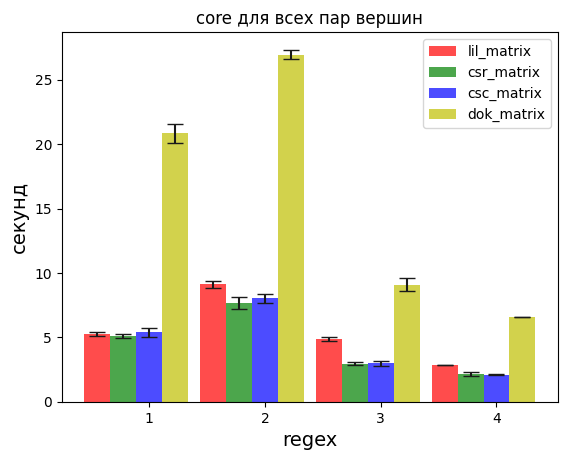

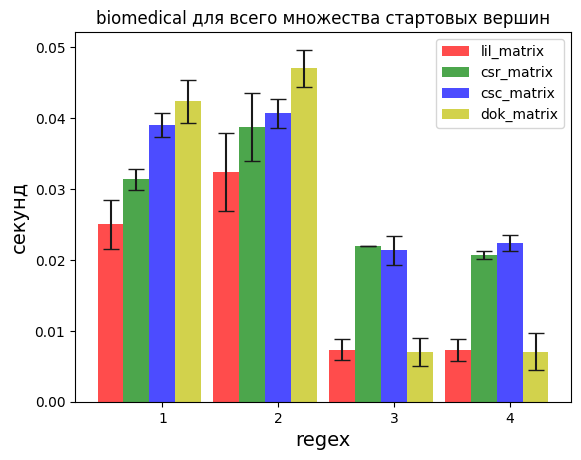

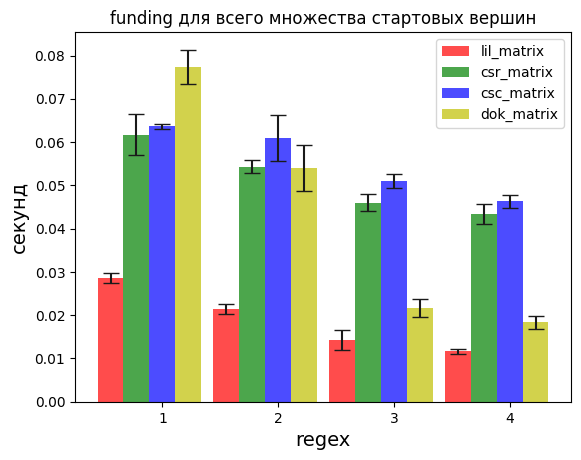

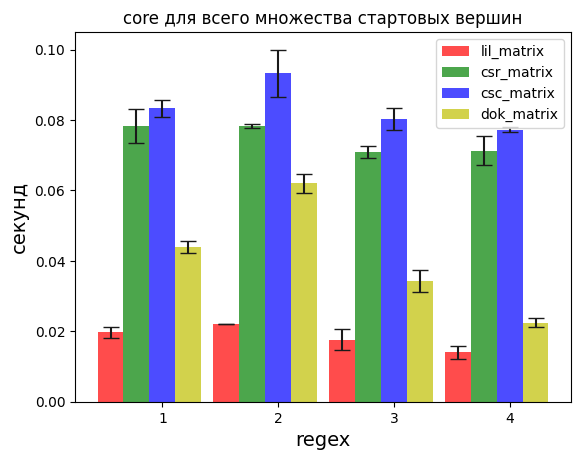

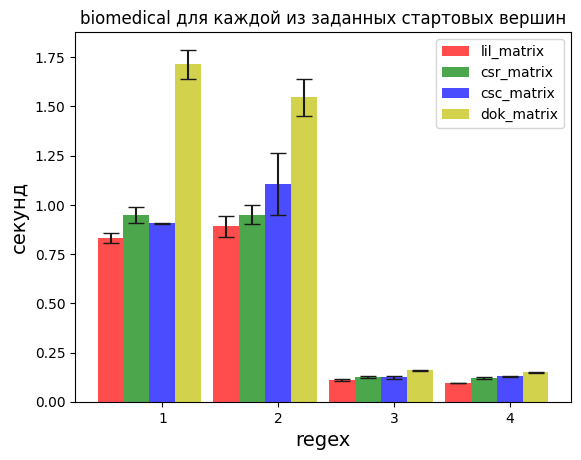

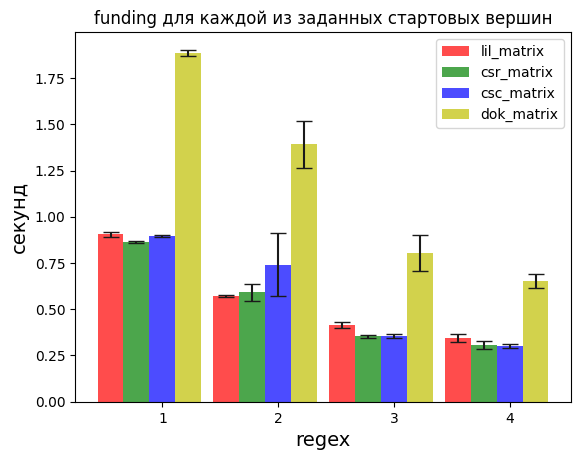

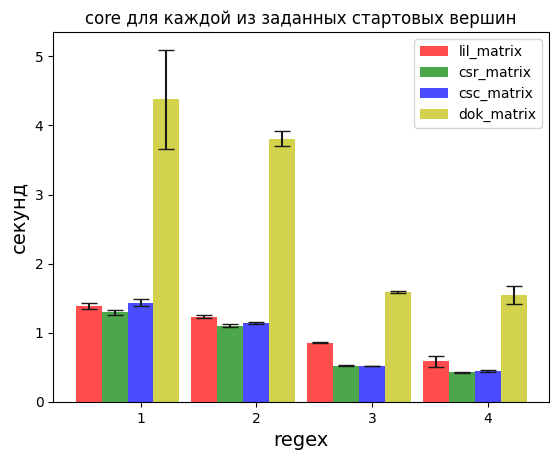

In [26]:
experiment()
experiment([25], False)
experiment([25], True)

Исходя из данных графиков для первой и третьей задач достижимости, все матрицы, за исключением `dok_matrix`,
отрабатывают примерно за равные промежутки времени.
Для меньшего графа `lil_matrix` оказался более подходящим представлением
разреженной матрицы, чем `csr` и `csc`, а для больших размеров выигрывает csr.

Для второй из задач достижимости уже не все так очевидно. `lil` матрица является
явным лидером, `csr` проявляет себя чуть лучше, чем `csc`, а `doc` сильно зависит от
входных данных (графа и регулярного выражения), и в зависимости от них может как
выигрывать у `csr` и `csc` матриц, так и сравняться с `lil` матрицей.


### 2. Начиная с какого размера стартового множества выгоднее решать задачу для всех пар и выбирать нужные?

Так как по результатам предыдущего эксперимента либо нет особой разницы между
различными вариантами матриц, либо выигрывает `lil_matrix`, дальнейшие эксперименты
будут проводиться именно с ней. Для ответа на данный вопрос было решено использовать
графы большего размера, так как маленькие проходят тест слишком быстро, и не дают
понять корреляцию между количеством стартовых вершин и временем выполнения.

C:\Users\slava\AppData\Local\Temp\ipykernel_15368\1001431462.py:46: DeprecationWarning: scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead
  mean_t = mean(times)


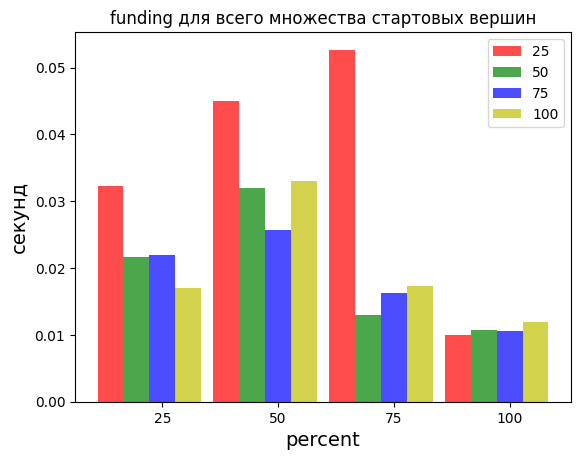

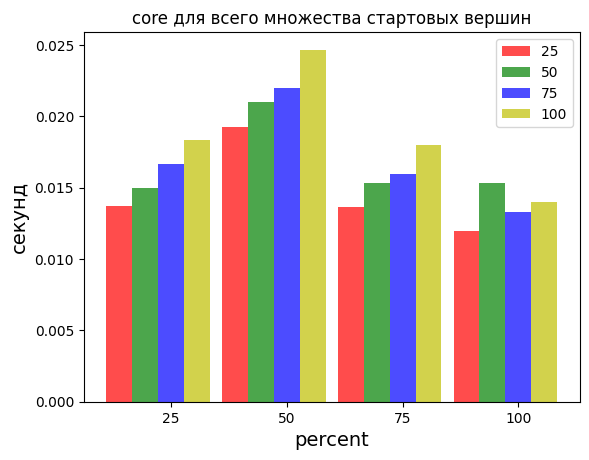

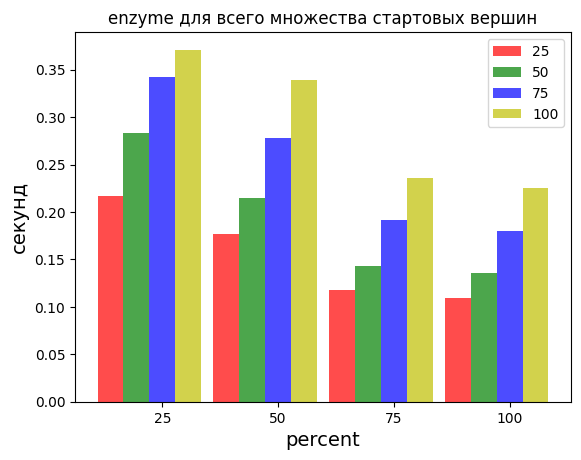

In [31]:
experiment([25, 50, 75, 100], False, [lil_matrix], taskn=2, graphs=['funding', 'core', 'enzyme'])

Как видно по результатам работы алгоритма для второй задачи, всегда выгоднее подсчитывать
сразу для нужного числа вершин.


### 3. На сколько решение второй задачи медленнее решения третьей при одинаковых начальных условиях?

C:\Users\slava\AppData\Local\Temp\ipykernel_15368\1001431462.py:46: DeprecationWarning: scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead
  mean_t = mean(times)


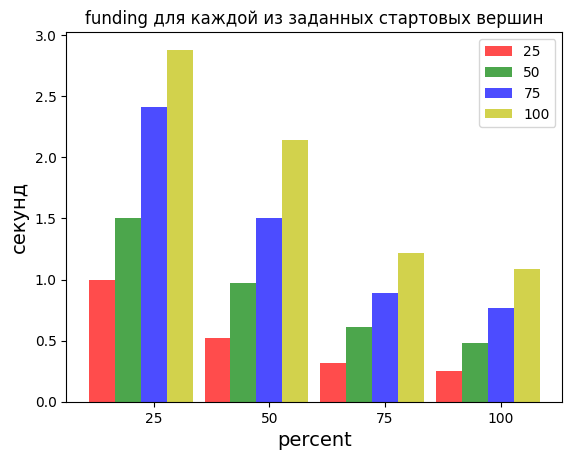

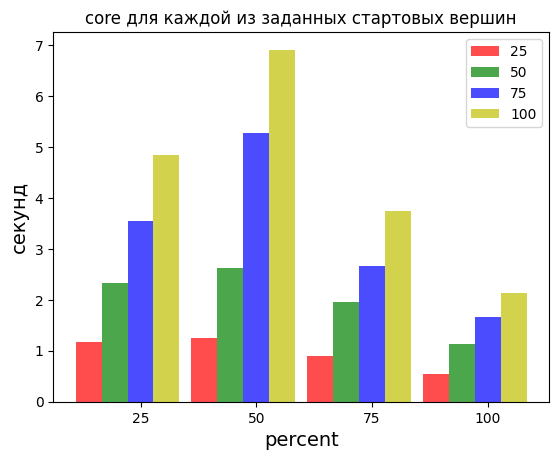

In [33]:
experiment([25, 50, 75, 100], True, [lil_matrix], taskn=3, graphs=['funding', 'core'])

Сравнивая данные диаграммы с тремя предыдущими, можно заметить, что время работы
алгоритма на данных графах для третьей задачи примерно на два порядка больше,
чем время при решении второй из задач достижимости.
